In [1]:
import datetime
import nltk
from nltk.text import TextCollection
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
from scipy import spatial
import seaborn as sns
from typing import List
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

from src import utils
from src.data import process_transcripts
from src.data.make_corpus import Corpus


ROOT_DIR = utils.get_project_root()
DATA_DIR = Path.joinpath(ROOT_DIR, 'data')
DATA_RAW_DIR = Path.joinpath(DATA_DIR, 'raw/cs-410')
INTERMEDATE_DATA_DIR = Path.joinpath(DATA_DIR, 'intermediate')

[nltk_data] Downloading package punkt to /home/bxjxrx7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bxjxrx7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/bxjxrx7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bxjxrx7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Process Raw Transcript File

In [2]:
file_name = '04_week-4/02_week-4-lessons/01_lesson-4-1-probabilistic-retrieval-model-basic-idea.en.srt'
file_path = Path.joinpath(DATA_RAW_DIR, file_name)

transcript_segments = process_transcripts.process_transcript(file_path)

# print out first 5 segments
for s in transcript_segments[:5]:
    print(s)

Segment(id=0, beg=datetime.datetime(1900, 1, 1, 0, 0, 0, 86000), end=datetime.datetime(1900, 1, 1, 0, 0, 7, 516000), text='[SOUND] This')
Segment(id=1, beg=datetime.datetime(1900, 1, 1, 0, 0, 7, 516000), end=datetime.datetime(1900, 1, 1, 0, 0, 10, 282000), text='lecture is about the Probabilistic Retrieval Model.')
Segment(id=2, beg=datetime.datetime(1900, 1, 1, 0, 0, 10, 282000), end=datetime.datetime(1900, 1, 1, 0, 0, 11, 805000), text='In this lecture,')
Segment(id=3, beg=datetime.datetime(1900, 1, 1, 0, 0, 11, 805000), end=datetime.datetime(1900, 1, 1, 0, 0, 17, 806000), text="we're going to continue the discussion of the Text Retrieval Methods.")
Segment(id=4, beg=datetime.datetime(1900, 1, 1, 0, 0, 17, 806000), end=datetime.datetime(1900, 1, 1, 0, 0, 22, 942000), text="We're going to look at another kind of very different way to design ranking")


In [3]:
with open(Path.joinpath(INTERMEDATE_DATA_DIR, 'corpuses.pkl'), 'rb') as f:
    corpuses = pickle.load(f)

corpus = corpuses['04_week-4/02_week-4-lessons/01_lesson-4-1-probabilistic-retrieval-model-basic-idea']
corpus.ts_cos_similarity

array([0.73067066, 0.58048699, 0.67270586, 0.70045895, 0.66516615,
       0.6823627 , 0.64045623, 0.51053308, 0.7189168 , 0.67754532,
       0.70728539])

[5, 11]
0.06202257328304191


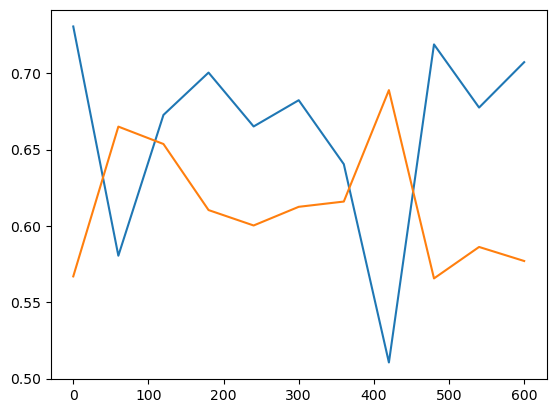

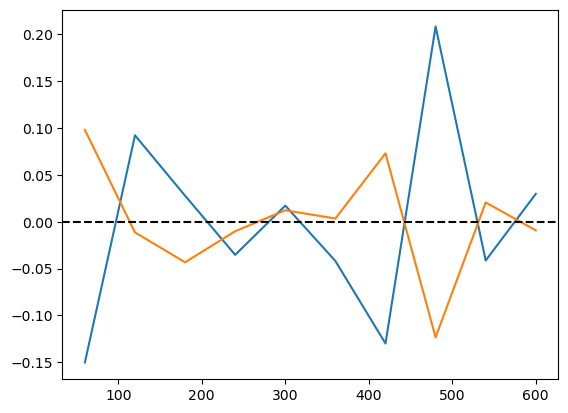

In [4]:
import ruptures as rpt
algo = rpt.Pelt(model="rbf").fit(corpus.ts_cos_similarity)
result = algo.predict(pen=0.025)
print(result)
print(np.std(corpus.ts_cos_similarity))

from matplotlib import pyplot as plt
x = [i*60 for i in range(len(corpus.ts_cos_similarity))]
plt.plot(x, corpus.ts_cos_similarity, x, corpus.ts_divergence_similarity)
plt.show()

plt.plot(x[1:], np.diff(corpus.ts_cos_similarity), x[1:], np.diff(corpus.ts_divergence_similarity))
plt.axhline(y=0, color='k', linestyle='--')
# plt.ylim([0, 1])
plt.show()


## Create Corpus

In [17]:
time_intervals = [30, 45, 60]
corpus_times = []

for interval in time_intervals:
    corpus = Corpus(transcript_segments, datetime.timedelta(seconds=interval))
    corpus.create_vocabulary(remove_stop_words=True)
    corpus.create_term_doc_freq_matrix()
    corpus.calc_similarity_ts()
    corpus_times.append(corpus)


6160
4464
3360


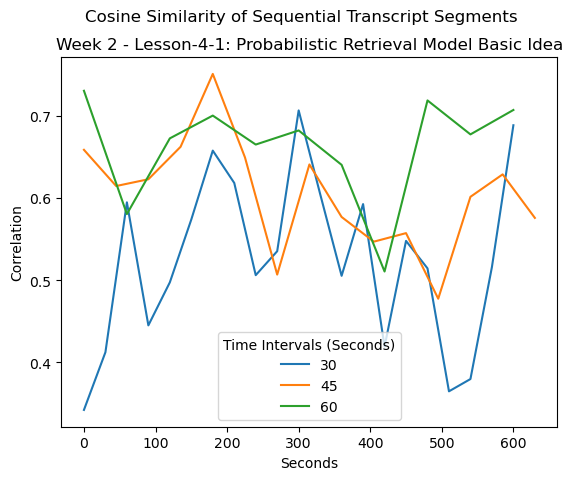

In [23]:
make_x_values = lambda idx: [i*time_intervals[idx] for i in range(len(corpus_times[idx].ts_cos_similarity))]
plt.plot(make_x_values(0), corpus_times[0].ts_cos_similarity, make_x_values(1), corpus_times[1].ts_cos_similarity, make_x_values(2), corpus_times[2].ts_cos_similarity)
plt.legend(['30', '45', '60'], title='Time Intervals (Seconds)')
plt.xlabel('Seconds')
plt.ylabel('Correlation')
plt.suptitle('Cosine Similarity of Sequential Transcript Segments')
plt.title('Week 2 - Lesson-4-1: Probabilistic Retrieval Model Basic Idea')

plt.show()

Text(0.5, 1.0, 'Week 2 - Lesson-4-1: Probabilistic Retrieval Model Basic Idea')

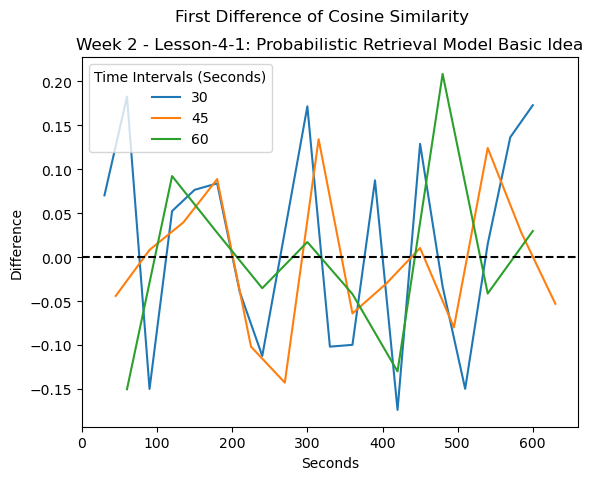

In [25]:
plt.plot(make_x_values(0)[1:], np.diff(corpus_times[0].ts_cos_similarity), make_x_values(1)[1:], np.diff(corpus_times[1].ts_cos_similarity), make_x_values(2)[1:], np.diff(corpus_times[2].ts_cos_similarity))
plt.axhline(y=0, color='k', linestyle='--')
plt.legend(['30', '45', '60'], title='Time Intervals (Seconds)')
plt.xlabel('Seconds')
plt.ylabel('Difference')
plt.suptitle('First Difference of Cosine Similarity')
plt.title('Week 2 - Lesson-4-1: Probabilistic Retrieval Model Basic Idea')

In [20]:
corpus_times[1].ts_cos_similarity

array([0.65875073, 0.61465474, 0.62288987, 0.6624212 , 0.75120477,
       0.64945169, 0.50678214, 0.64091819, 0.57694508, 0.54688424,
       0.55727821, 0.47738172, 0.60151005, 0.62885047, 0.57582892])

In [8]:
transcript_segments

[Segment(id=0, beg=datetime.datetime(1900, 1, 1, 0, 0, 0, 86000), end=datetime.datetime(1900, 1, 1, 0, 0, 7, 516000), text='[SOUND] This'),
 Segment(id=1, beg=datetime.datetime(1900, 1, 1, 0, 0, 7, 516000), end=datetime.datetime(1900, 1, 1, 0, 0, 10, 282000), text='lecture is about the Probabilistic Retrieval Model.'),
 Segment(id=2, beg=datetime.datetime(1900, 1, 1, 0, 0, 10, 282000), end=datetime.datetime(1900, 1, 1, 0, 0, 11, 805000), text='In this lecture,'),
 Segment(id=3, beg=datetime.datetime(1900, 1, 1, 0, 0, 11, 805000), end=datetime.datetime(1900, 1, 1, 0, 0, 17, 806000), text="we're going to continue the discussion of the Text Retrieval Methods."),
 Segment(id=4, beg=datetime.datetime(1900, 1, 1, 0, 0, 17, 806000), end=datetime.datetime(1900, 1, 1, 0, 0, 22, 942000), text="We're going to look at another kind of very different way to design ranking"),
 Segment(id=5, beg=datetime.datetime(1900, 1, 1, 0, 0, 22, 942000), end=datetime.datetime(1900, 1, 1, 0, 0, 27, 584000), text=

In [16]:
datetime.timedelta(interval)

datetime.timedelta(days=30)